In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import astropy.constants as cons
from matplotlib.colors import LogNorm
import astropy.units as u
#all of the important fundamental constants are put into cgs units just for convenience but this could be switched to SI if needed
c=cons.c.cgs.value
G=cons.G.cgs.value
h=cons.h.cgs.value
hbar=cons.hbar.cgs.value
Msun=cons.M_sun.cgs.value
Rsun=cons.R_sun.cgs.value
mp=cons.m_p.cgs.value
me=cons.m_e.cgs.value
mn=cons.m_n.cgs.value
kB=cons.k_B.cgs.value
u=cons.u.cgs.value
mu_e=2 #mean mass per electron for He-core or C/O core composition
m_u = 1/cons.N_A.cgs.value #atomic mass unit in grams

## part b

In [38]:
def P_from_rho(rho):
    x = x_from_rho(rho)
    return P_from_x(x)
def P_from_x(x):
    lamb = hbar/(me*c)
    return me*c**2/(lamb**3)*phi_from_x(x)
def phi_from_x(x):
    return (1/8*np.pi**2)*(x*np.sqrt(1+x**2)*(2*x**2/3-1)+np.log(x+np.sqrt(1+x**2)))
def x_from_rho(rho):
    lamb = hbar/(me*c)
    return lamb*(3*np.pi**2*rho/u*mu_e)**(1/3)

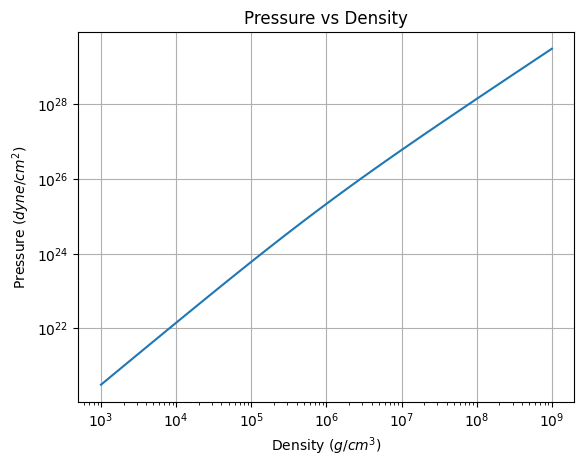

In [39]:
rho = np.logspace(3,9,100)
P = P_from_rho(rho)
plt.plot(rho, P)
plt.title("Pressure vs Density")
plt.xlabel("Density ($g/cm^3$)")
plt.ylabel("Pressure ($dyne/cm^2$)")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

## part c

In [97]:
def newton_raphson(func, dfunc, x0, tol=1e-10, max_iter=100000):
    x = x0
    for i in range(max_iter):
        fx = func(x)
        dfx = dfunc(x)
        if dfx == 0:
            raise ValueError("Derivative is zero. No solution found.")
        x_new = x - fx / dfx
        
        print(f"Iteration {i}: x = {x_new}, f(x) = {fx}, f'(x) = {dfx}, f(x)/f'(x) = {fx/dfx}")
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
        if np.isnan(x) or np.isinf(x):
            raise ValueError("NaN or Inf detected. No solution found.")
    raise ValueError("Maximum iterations reached. No solution found.")

In [98]:
def rho_from_P(Pin, tol=1e-10, relativistic=False):
    #in the following cases, r represents rho
    func = lambda r: P_from_rho(r) - Pin
    #df/dr = dP/dphi*dphi/dx*dx/dr
    dxdr = lambda r: (hbar/(me*c))*((3*np.pi**2/u*mu_e)**(1/3))*1/(3*r**(2/3))
    dpdphi = me*c**2/(hbar/(me*c))**3
    #note: I didn't feel like simplifying this expression, so it looks a bit ugly
    dphidx = lambda r: (1/8*np.pi**2)*np.sqrt(1+r**2)*(2*r**2/3 -1)+(r**2/np.sqrt(1+r**2))*(2*r**2/3 -1)+r*np.sqrt(1+r**2)*(4*r/3 -1)+1/(r+np.sqrt(1+r**2))+r/(r*np.sqrt(1+r**2)+1+r**2)
    dfunc = lambda r: dpdphi*dphidx(x_from_rho(r))*dxdr(r)
    
    if relativistic:
        k = 3**(1/3)*np.pi**(2/3)*hbar*c/(4*mu_e**(4/3)*m_u**(4/3))
        r0 = (Pin/k)**(3/4)
    else:
        k = 3**(2/3)*np.pi**(4/3)*hbar**2/(5*mu_e**(5/3)*m_u**(5/3)*me)
        r0 = (Pin/k)**(3/5)
    r_sol = newton_raphson(func, dfunc, r0, tol=tol)
    #lamb = hbar/(me*c)
    #return (r_sol/lamb)**3*u*mu_e/(3*np.pi**2)
    return r_sol

In [ ]:
#testing rho_from_P
true_rho = np.logspace(3,9,100)
true_P = [P_from_rho(r) for r in true_rho]
#I'm seeing that basically the derivative is order e34 meanwhile function is order e23 so get ratio of onlie e-11 and x doesn't change 
#and the ratio also doesn't seem to change over time for some reason
#i think it might be that my calculations of the derivative are wrong because i'm passing rho to all of them but i should be passing x to some 
#i have no clue idk but it's def something with derivatives I feel like
calc_rho = [rho_from_P(p) for p in true_P]
plt.plot(true_rho, calc_rho,label='Calculated Density')
plt.plot(np.logspace(3,9,10), np.logspace(3,9,10), linestyle='--', color='red', label='y=x')
plt.xscale("log")
plt.yscale("log")
plt.title("Calculated Density vs True Density")
plt.xlabel("True Density")
plt.ylabel("Calculated Density")
plt.legend()
plt.show()


Iteration 0: x = 73753.45648231584, f(x) = 2.787003644028338e+23, f'(x) = -2.4103416205330117e+19, f(x)/f'(x) = -11562.69144708223
Iteration 1: x = 90799.91218979387, f(x) = 3.6709900558786837e+23, f'(x) = -2.1535210127394836e+19, f(x)/f'(x) = -17046.455707478028
Iteration 2: x = 118464.46392344552, f(x) = 5.130075540356092e+23, f'(x) = -1.8543859267077075e+19, f(x)/f'(x) = -27664.551733651642
Iteration 3: x = 171202.65551984677, f(x) = 7.853772613971157e+23, f'(x) = -1.48920021264193e+19, f(x)/f'(x) = -52738.19159640124
Iteration 4: x = 311534.4026701644, f(x) = 1.4101199480685295e+24, f'(x) = -1.0048474252644104e+19, f(x)/f'(x) = -140331.74715031765
Iteration 5: x = 1843779.0903765587, f(x) = 3.6072669732728224e+24, f'(x) = -2.3542368932422364e+18, f(x)/f'(x) = -1532244.6877063944
Iteration 6: x = -401184.6864466807, f(x) = 5.288232593168461e+25, f'(x) = 2.355598182814171e+19, f(x)/f'(x) = 2244963.7768232394
Iteration 7: x = nan, f(x) = nan, f'(x) = nan, f(x)/f'(x) = nan


c:\Users\teg\miniconda3\envs\astroresearch\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
c:\Users\teg\miniconda3\envs\astroresearch\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


ValueError: NaN or Inf detected. No solution found.

## part d

In [54]:
def derivative(r, m, P):
    #returns dm/dr and dP/dr
    dr = [r[i+1]-r[i] for i in range(len(r)-1)]
    dm = [m[i+1]-m[i] for i in range(len(m)-1)]
    dP = [P[i+1]-P[i] for i in range(len(P)-1)]
    dmdr = np.array([dm[i]/dr[i] for i in range(len(dr))])
    dPdr = np.array([dP[i]/dr[i] for i in range(len(dr))])
    return np.stack((dmdr, dPdr))

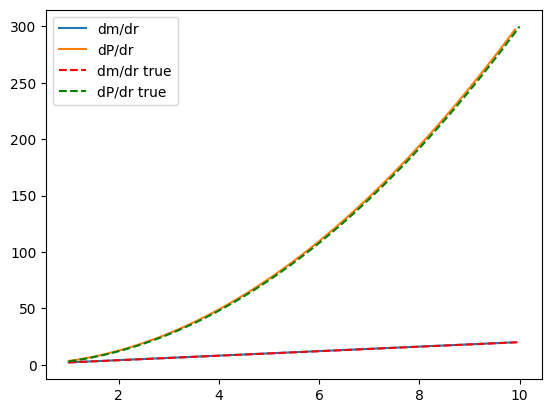

In [55]:
#test of derivative function 
r = np.linspace(1,10,100)
m = r**2
P = r**3
dydr = derivative(r, m, P)
dmdr = dydr[0]
dPdr = dydr[1]
plt.plot(r[:-1], dmdr, label='dm/dr')
plt.plot(r[:-1], dPdr, label='dP/dr')
plt.plot(r, 2*r, linestyle='--', color='red', label='dm/dr true')
plt.plot(r, 3*r**2, linestyle='--', color='green', label='dP/dr true')
plt.legend()
plt.show()